In [84]:
# needed libraries
import csv
import random
import math
import numpy as np
import pandas as pd
import sklearn.metrics as metrics

# visualisations
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler


### Uploading the data

In [85]:
df = pd.read_csv("data.csv")

Let's display some info about our dataset to get familiar with it.

In [86]:
display(df.info())
print("="*80, '\n')
display(df.head(5))
print("="*80, '\n')
display(df.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2718 entries, 0 to 2717
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2718 non-null   object 
 1   Year                             2718 non-null   int64  
 2   Status                           2718 non-null   object 
 3   Life expectancy                  2718 non-null   float64
 4   Adult Mortality                  2718 non-null   float64
 5   infant deaths                    2718 non-null   int64  
 6   Alcohol                          2564 non-null   float64
 7   percentage expenditure           2718 non-null   float64
 8   Hepatitis B                      2188 non-null   float64
 9   Measles                          2718 non-null   int64  
 10  BMI                              2692 non-null   float64
 11  under-five deaths                2718 non-null   int64  
 12  Polio               

None

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


Country                             183
Year                                 16
Status                                2
Life expectancy                     359
Adult Mortality                     423
infant deaths                       195
Alcohol                            1055
percentage expenditure             2185
Hepatitis B                          87
Measles                             909
BMI                                 600
under-five deaths                   239
Polio                                73
Total expenditure                   792
Diphtheria                           81
HIV/AIDS                            197
GDP                                2317
Population                         2110
thinness  1-19 years                194
thinness 5-9 years                  200
Income composition of resources     613
Schooling                           173
dtype: int64

### Data preprocessing

Let's begin with transforming object features - `country` and `status` to numerical ones. Because our future models cannot deal with text features.

In [87]:
def object_to_num(data, features):
    """
    Transforms object features to numerical in each dataset in dataframes.
    
    Args:
        data: dataframe to process.
        features: List of features, which must be transformed.
    """
    for feature in features:
        if feature in data.columns and data[feature].dtype == 'object':
            data[feature] = data[feature].astype('category').cat.codes

In [88]:
object_to_num(df, ['Country', 'Status'])

We have 21 features, which is relatively a lot. Let's use filter methods to find irrelevant and redundant features, which can be removed.  

Firstly, let's examine correlation with the target variable. Features, which have low correlations can be removed.

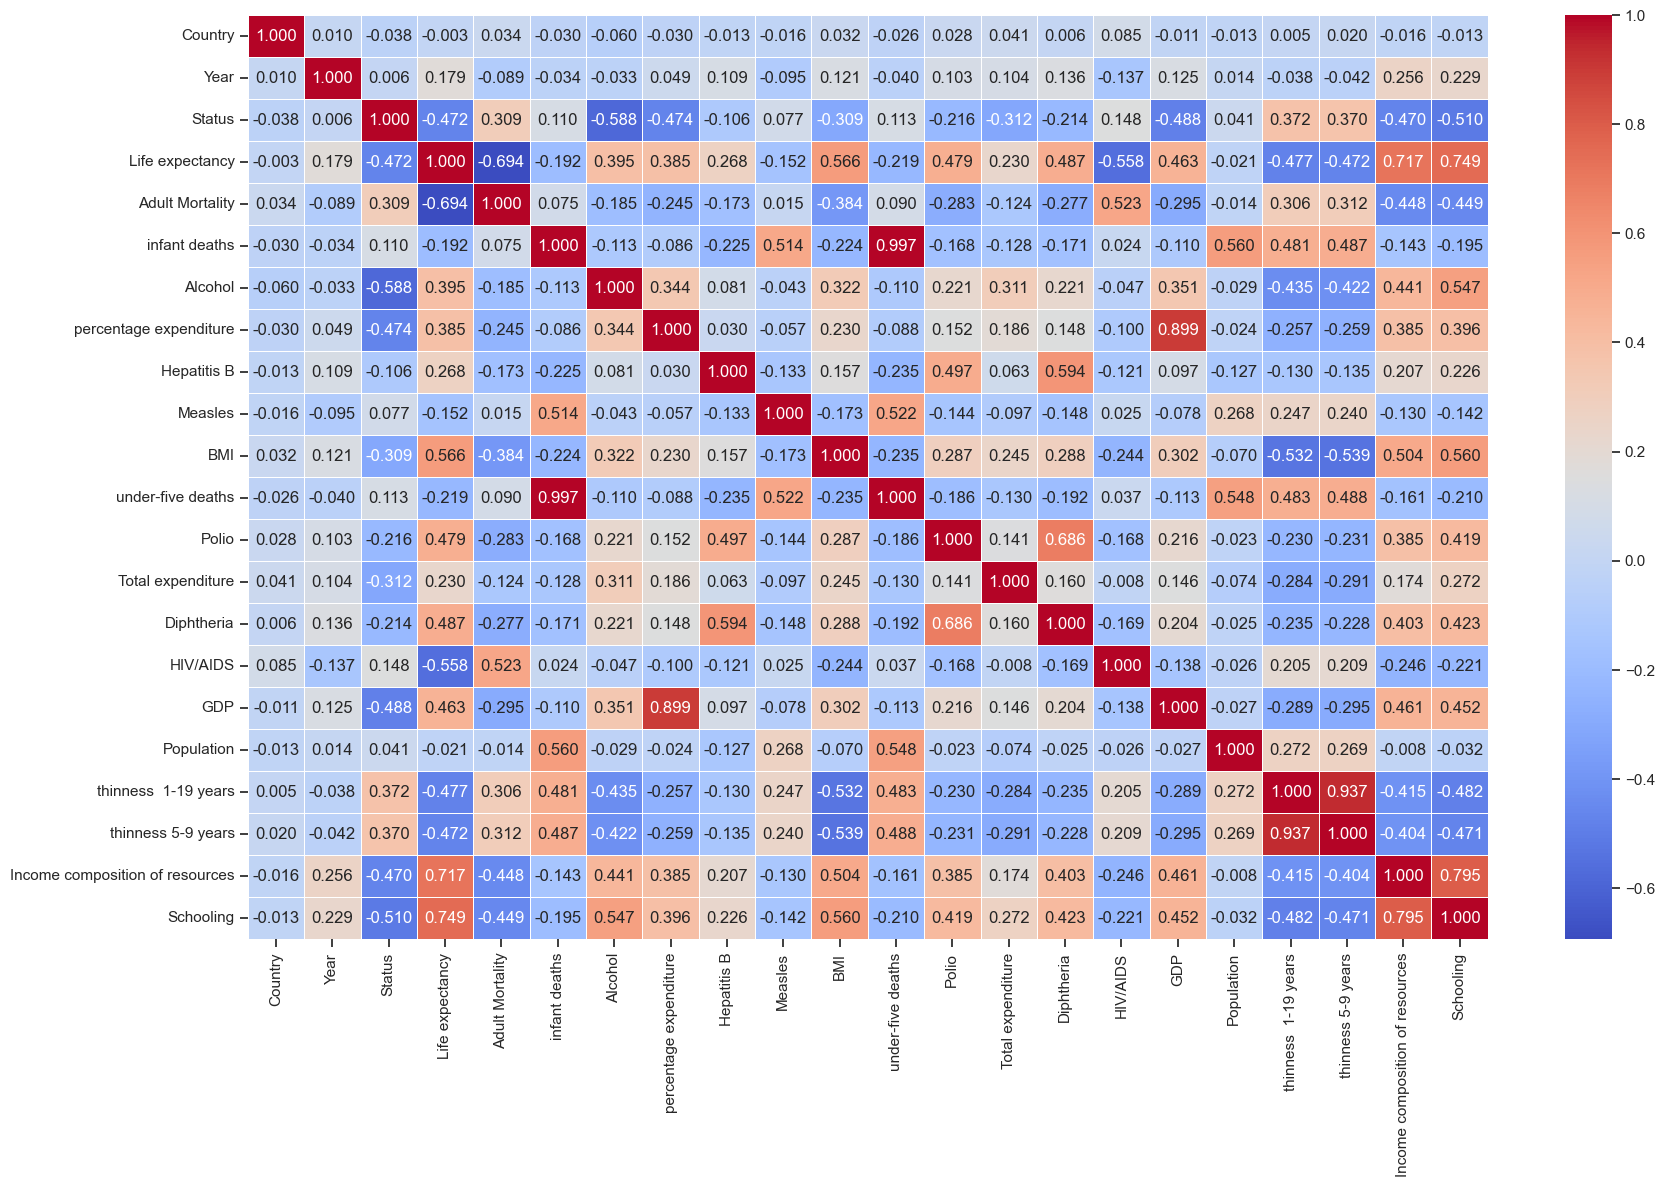

In [89]:
# calculate correlations
correlation_matrix = df.corr()

plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5)

# Show the plot
plt.show()

Low degree: When the value lies below +- 0.29, then it is said to be a small correlation.   
High degree: If the coefficient value lies between ± 0.50 and ± 1, then it is said to be a strong correlation. (According to statisticssolutions.com)  

Let's delete: Infant deaths, Hepatitis B, Measles, under-five deaths, Total expenditure, Population, Year. (Low correlation with target variable). Feature country has also low correlation, but we keep it for future usage.

We can also remove some of the features that are highly correlated with each other and are therefore redundant - Infant deaths and under-five deaths (second one is already removed), percentage expenditure and GDP (GDP has more missing values, let's remove it), thinness 1-19 years and thinness 5-9 years (first one has slightly bigger correlation with target var).

In [90]:
columns_to_drop = ["Population", "Measles", "infant deaths", "under-five deaths", "Total expenditure", "Hepatitis B", "GDP", "thinness 5-9 years", "Year"]
df.drop(columns=columns_to_drop, inplace=True)

Let's explore data distribution of each feature against target variable. With that we can detect outliers and see if there is any type of relationship between feature and life expectancy.

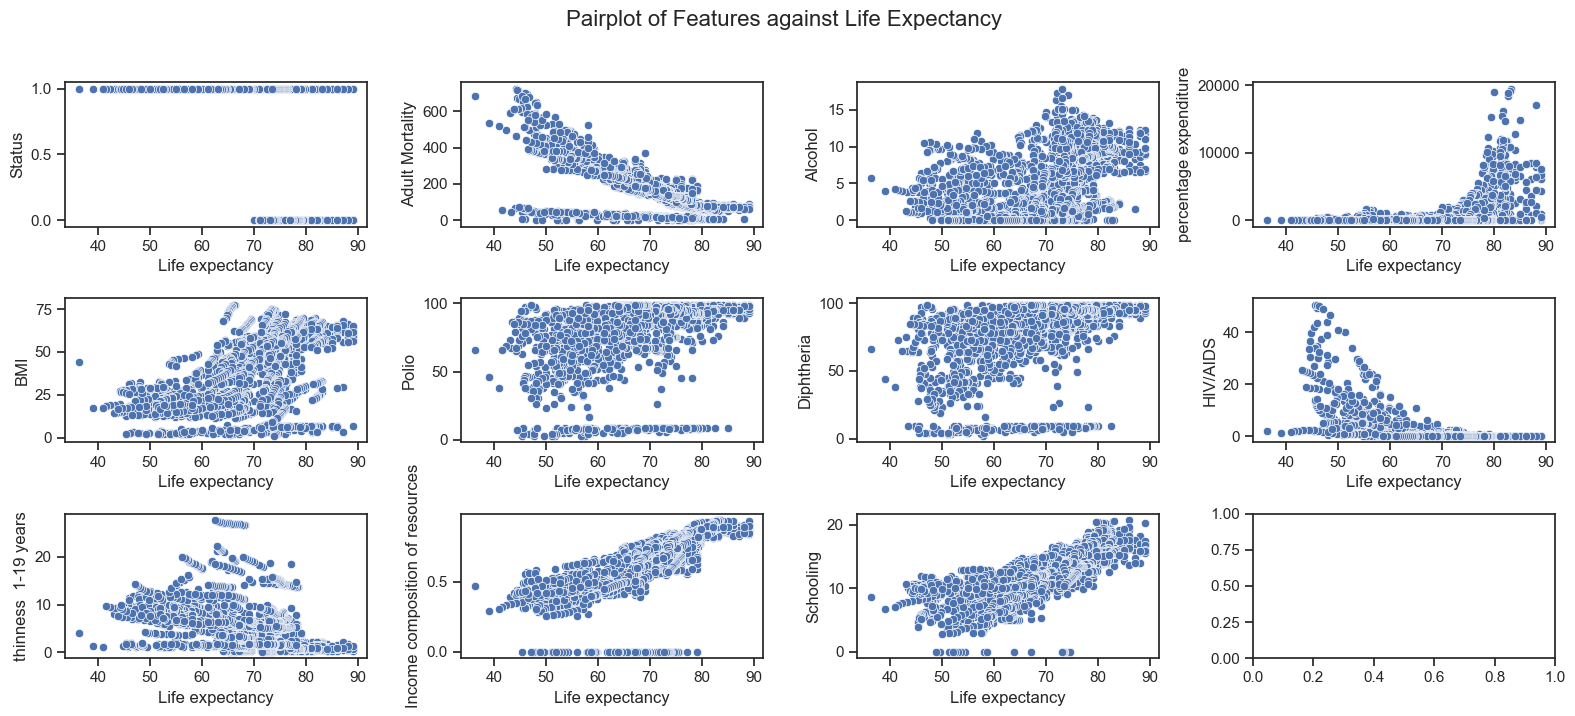

In [91]:
sns.set(style="ticks")
df_columns = [col for col in df.columns if col not in ["Country", "Life expectancy"]]

# set up a grid of subplots
num_rows = 3  # adjust the number of rows
num_cols = 4  # adjust the number of columns
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16,7))

# flatten the axes array for easy iteration
axes = axes.flatten()

# loop through the subplots and plot the data
for i, ax in enumerate(axes):
    if i < len(df_columns):
        sns.scatterplot(x="Life expectancy", y=df_columns[i], data=df, ax=ax, marker='o')

fig.suptitle("Pairplot of Features against Life Expectancy", y=1.02, fontsize=16)

plt.tight_layout()
plt.show()

There are certainly some outliers in features - adult mortality (which lies far enough from the main cluster of points), BMI, Polio, Diphtheria and others.

  
 Feature percentage expenditure cannot be more than 100% according to the definition otherwise it would imply that the country is spending more on healthcare than its entire economic output. Let's replace these outliers with NaNs. Other outliers from other features are not so obvious so let's just keep them with keeping in mind that there are many techniques to remove them (substituting with mean or predicted values etc.)

In [92]:
# replace values greater than 100 with NaN
df.loc[df["percentage expenditure"] > 100, "percentage expenditure"] = np.nan

#### Dividing the data

Before dealing with missing values let’s divide the dataset into the target variable (Ydata) that we want to predict and the matrix of features (Xdata) from which we will predict. In our case, the target variable is life expectancy. (We do that before to avoid methodical errors)

In [97]:
Xdata = df.drop('Life expectancy', axis=1)
Ydata = df['Life expectancy']

Then we divide the data into training (60%), validation (20%) and testing (20%) parts. There is no need of keeping the chronological or any other order of data, so we can pseudorandomly divide the data with function train_test_split from sklearn.

In [98]:
seed = 10

Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xdata, Ydata, train_size=0.6, random_state=seed)
Xval, Xtest, Yval, Ytest = train_test_split(Xtest, Ytest, train_size=0.5, random_state=seed)

# let's check our parts
print("Before:")
print("Xdata  -", Xdata.shape, "Ydata  -", Ydata.shape)
print()
print("After:")
print("Xtrain -", Xtrain.shape, "Ytrain -", Ytrain.shape)
print("Xval   -", Xval.shape, " Yval   -", Yval.shape)
print("Xtest  -", Xtest.shape, " Ytest  -", Ytest.shape)

Before:
Xdata  - (2718, 12) Ydata  - (2718,)

After:
Xtrain - (1630, 12) Ytrain - (1630,)
Xval   - (544, 12)  Yval   - (544,)
Xtest  - (544, 12)  Ytest  - (544,)


#### Dealing with missing values

There are no many missing values in our dataset, the maximum number (beside `percentage expenditure`) has `Alcohol` feature 2718 - 2564 = 154 (5,67%), let's just fill them with mean values of each column from training dataset. To make new values more realistic, let's calculate mean values for every feature for every country (For example, consumption of the alcohol in the ordinary EU country is certainly higher than in a muslim one, so to make these numbers more real let's cycle for every country) 

In [95]:
# going through every column
for column in Xtrain.columns:
    # going through every country
    for country in Xtrain["Country"].unique():
        # calculate mean values for certain feature and certain country in training dataset to avoid methodical error
        mean_value = Xtrain.loc[Xtrain["Country"] == country, column].mean()
        # if there is no data for that country, let's take mean from the whole column
        if np.isnan(mean_value):
            mean_value = Xtrain[column].mean()
        # in each part of dataset
        for dataset in [Xtrain, Xval, Xtest]:
                dataset.loc[dataset["Country"] == country, column] = dataset.loc[dataset["Country"] == country, column].fillna(mean_value)

In [96]:
# now we can drop country feature because of low corr
for dataset in [Xtrain, Xval, Xtest]:
    dataset.drop(columns=["Country"], inplace=True)

### Creating CustomRandomForest

In [14]:
class CustomRandomForest:
    
    def __init__(self, n_estimators, max_samples, max_depth, **kwargs):
        self.n_estimators = n_estimators
        self.max_samples = max_samples 
        self.max_depth = max_depth
        self.random_forest = []
        
    def fit(self, X, y):
        random.seed(42)
        
        # creating trees
        for _ in range(0, self.n_estimators):
            # boostrap
            x_train = pd.DataFrame(columns=X.columns)
            y_train = pd.Series(name=y.name)
            
            for _ in range(0, self.max_samples):
                # choose random index
                random_index = random.randrange(0, X.shape[0])
                # insert
                x_train.loc[x_train.shape[0]] = X.iloc[random_index]
                y_train.loc[x_train.shape[0]] = y.iloc[random_index]

            # create and train a tree
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=42)
            tree.fit(x_train, y_train)
            
            # append the tree to our forest
            self.random_forest.append(tree)
        return self
        
        
    def predict(self, X):
        ypredicted = np.zeros((X.shape[0],))
        
        # predict for every row
        for i in range(0, X.shape[0]):
            # getting predictions from each tree
            predictions = []
            for tree in self.random_forest:
                predictions.append(tree.predict(X.iloc[[i]]))
            # calculate average, it's our prediction
            prediction = sum(predictions) / len(predictions)
            ypredicted[i] = prediction
        
        return ypredicted

### Applying CustomRandomForest

Using a Random Forest model for predicting life expectancy seems like a reasonable choice with usage of our dataset. Random Forest is a versatile and robust ensemble learning method that can handle a mix of numerical and categorical features, as well as complex relationships between variables.  

It can capture non-linear relationships between features and the target variable. Life expectancy is likely influenced by a combination of linear and non-linear factors, and Random Forests can model these complex interactions effectively. By aggregating predictions from multiple decision trees, Random Forests reduce the risk of overfitting and provide more stable and accurate predictions despite its not complex implementation.

As hyperparameters, we can set up n_estimators - number of individual decision trees in our ensemble model, max_depth - max depth of decision trees and max_samples - size of training dataset for each tree, which is created during bootsraping. 

In [15]:
def best_params_forest(x_train, y_train, x_val, y_val):
    """
    Find the best hyperparameters for a CustomRandomForest model based on validation data.
    
    Parameters:
    - x_train (pd.DataFrame): The training features.
    - y_train (pd.Series): The training labels.
    - x_val (pd.DataFrame): The validation features.
    - y_val (pd.Series): The validation labels.
    
    Returns:
    - best_params (dict): The best hyperparameters found based on the lowest RMSE on validation data.
    """
    length_of_df = x_train.shape[0]
    # hyperparameters
    param_grid = {
        "n_estimators": range(5, 30, 5),
        "max_depth": range(3, 8),
        "max_samples": [math.ceil(length_of_df / 5), math.ceil(length_of_df / 4), math.ceil(length_of_df / 2)] # 20%, 25% and 50% of dataset
        # statistics from the internet tells that usually 20% of data is enough to reach max RMSE, but of course it depends on dataset
        # So I have set up these not big values to reduce training time
    }
    param_comb = ParameterGrid(param_grid)
    
    # for saving metrics on validation data
    val_metrics = []
    # go through every set of hyperparameters
    for params in param_comb:
        # creating
        model = CustomRandomForest(**params)
        # training
        model.fit(x_train, y_train)
        # write in accuracy score
        val_metrics.append(metrics.mean_squared_error(y_val, model.predict(x_val), squared = False))
    
    # best hyperparameters with the lowest RMSE
    best_params = param_comb[np.argmin(val_metrics)]
    print(f"The best params {best_params} with validation RMSE {min(val_metrics):.4f}.")
    return best_params

In [16]:
# finding best hyperparameters
best_params = best_params_forest(Xtrain, Ytrain, Xval, Yval)

The best params {'n_estimators': 15, 'max_samples': 815, 'max_depth': 7} with validation RMSE 2.4103.


In [17]:
# creating random forest with the best hyperparameters
clfRFb = CustomRandomForest(**best_params).fit(Xtrain, Ytrain)

Random Forest is invariant to monotonic transformations of the input features. This means that if we scale or normalize the features, the resulting forest and its predictions will be the same. So, normalization is not strictly required for this model as much as for others (for example KNN), but it's always a good practice to experiment with different preprocessing techniques.

So let's normalize our parts of dataset with min/max and standardization methods. Then check if our model improves or not.  

In [18]:
# min/max method
min_max_scaler = MinMaxScaler()

Xtrain_min_max = pd.DataFrame(data=min_max_scaler.fit_transform(Xtrain, Ytrain), columns=Xtrain.columns, index=Xtrain.index)
Xval_min_max = pd.DataFrame(data=min_max_scaler.fit_transform(Xval), columns=Xval.columns, index=Xval.index)

In [19]:
# standardization
standard_scaler = StandardScaler()

Xtrain_stand = pd.DataFrame(data=standard_scaler.fit_transform(Xtrain), columns=Xtrain.columns, index=Xtrain.index)
Xval_stand = pd.DataFrame(data=standard_scaler.fit_transform(Xval), columns=Xval.columns, index=Xval.index)

In [20]:
# finding the best hyperparameters for min/max data
best_params_min_max = best_params_forest(Xtrain_min_max, Ytrain, Xval_min_max, Yval)

The best params {'n_estimators': 15, 'max_samples': 815, 'max_depth': 7} with validation RMSE 2.4211.


In [21]:
# finding the best hyperparameters for stand data
best_params_stand = best_params_forest(Xtrain_stand, Ytrain, Xval_stand, Yval)

The best params {'n_estimators': 25, 'max_samples': 815, 'max_depth': 7} with validation RMSE 2.7802.


As we have expected normalisation of data does not improve RMSE, so our best Random Forest with selected hyperparameters takes not normalized data.  

Let's calculate RMSE and MAE on validation data for our best model to compare later with others.

In [22]:
def calcul_rmse_mae(model, x_val, y_val):
    """
    Calculate Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) for a given model on validation data.
    
    Parameters:
    - model (object): A trained regression model with a 'predict' method.
    - x_val: Features of the validation data.
    - y_val: Targets of the validation data.
    """
    # make predictions on the validation data
    predictions = model.predict(x_val)
    
    # Calculate RMSE and MAE
    rmse = mean_squared_error(y_val, predictions, squared=False)
    mae = mean_absolute_error(y_val, predictions)
    
    # display the results
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    print(f'Mean Absolute Error (MAE): {mae:.4f}')

In [23]:
calcul_rmse_mae(clfRFb, Xval, Yval)

Root Mean Squared Error (RMSE): 2.4103
Mean Absolute Error (MAE): 1.6288


### Applying Linear Regression

Linear regression is a commonly used technique for predicting a continuous target variable like life expectancy. The main disadvantage of that model in our case can be non-linear relationships between target variable and features. Linear regression assumes a linear relationship between the independent and dependent variables. If the relationships are non-linear, linear regression may not capture the underlying patterns effectively.

As the primary hyperparameters for linear regression we can set up `fit_intercept` parameter, if set to True (default), the model will include an intercept term in the linear equation. Also, we can either normalize our data or not (It's sort of hyperparameter). Let's find the best ones.

In [24]:
def linear_regression(intercept, x_train, y_train, x_val, y_val):
    """
    Perform linear regression using scikit's LinearRegression model.
    
    Parameters:
    - intercept (bool): Whether to fit an intercept term in the model.
    - x_train: Training data features.
    - y_train: Training data target.
    - x_val: Validation data features.
    - y_val: Validation data target.
    """
    model = LinearRegression(fit_intercept=intercept).fit(x_train,y_train)
    
    # visualisation of predictions
    predictions = model.predict(x_val)
    plt.scatter(y_val, predictions)
    plt.plot([0,50], [0,50], 'r')
    plt.show()

    print('Training RMSE:', mean_squared_error(np.array(y_train), model.predict(x_train), squared=False))
    print('Validation RMSE:', mean_squared_error(np.array(y_val), predictions, squared=False))

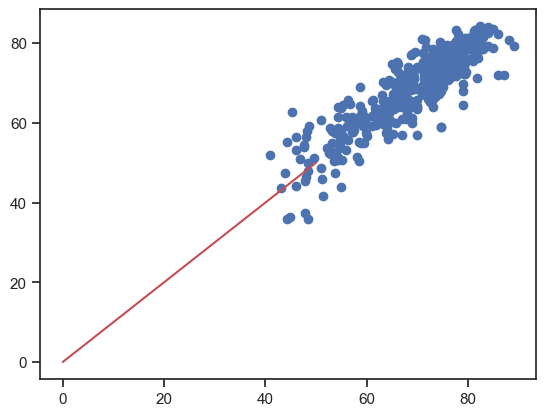

Training RMSE: 4.315422453165714
Validation RMSE: 4.337157472413424


In [25]:
# include intercept
linear_regression(True, Xtrain, Ytrain, Xval, Yval)

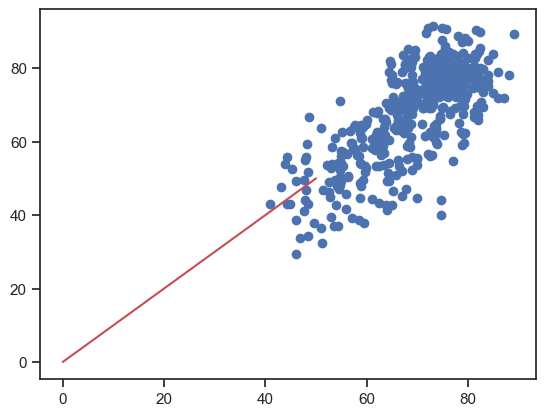

Training RMSE: 8.094372622284698
Validation RMSE: 8.283102194901819


In [26]:
# does not include intercept
linear_regression(False, Xtrain, Ytrain, Xval, Yval)

Excluding intercept from equation definitely worsens RMSE, let's check two types of normalization with intercept.

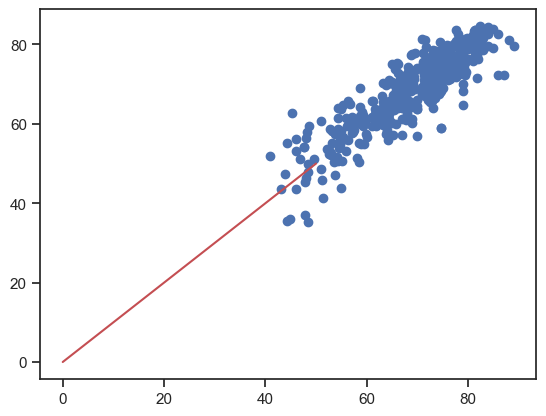

Training RMSE: 4.315422453165714
Validation RMSE: 4.346331026098712


In [27]:
# min/max normalization 
linear_regression(True, Xtrain_min_max, Ytrain, Xval_min_max, Yval)

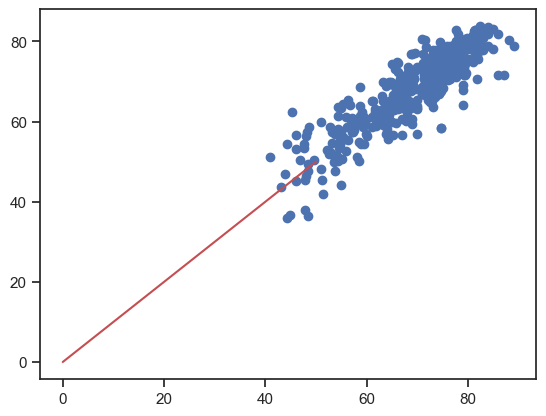

Training RMSE: 4.315422453165714
Validation RMSE: 4.387292556809178


In [28]:
# standard normalization 
linear_regression(True, Xtrain_stand, Ytrain, Xval_stand, Yval)

In conclusion, our best model of linear regression do have intercept and was trained on non-normalized data.

In [29]:
# best linear regression model
clfLRb = LinearRegression().fit(Xtrain, Ytrain)

In [30]:
# RMSE and MAE for the best model
calcul_rmse_mae(clfLRb, Xval, Yval)

Root Mean Squared Error (RMSE): 4.3372
Mean Absolute Error (MAE): 3.2442


### Applying Decision Tree

Decision tree is a reasonable choice for predicting life expectancy based on the provided features, especially if interpretability and feature importance are essential. It can be not so powerful as previous models, but with that we can compare ensemble of decision trees, which is represented by Random Forest and decision tree itself. 

As hyperparameters, we can set up max_depth of our tree and criterion, which is used in calculation of information gain. As for the random forest, normalization of data is not expected to help, so we will skip that step.

In [31]:
# hyperparameters
param_grid = {
    "max_depth": range(1, 15),
    "criterion": ["poisson", "squared_error"]
}
param_comb = ParameterGrid(param_grid)

# for saving metrics on validation data
val_metrics = []
# for saving metrics on training data
train_metrics = []

# go through every set of hyperparameters
for params in param_comb:
    # creating and training
    model = DecisionTreeRegressor(**params, random_state=42).fit(Xtrain, Ytrain)
    # write in accuracy score
    val_metrics.append(metrics.mean_squared_error(Yval, model.predict(Xval), squared = False))
    train_metrics.append(metrics.mean_squared_error(Ytrain, model.predict(Xtrain), squared = False))

# best hyperparameters with the lowest RMSE
best_params = param_comb[np.argmin(val_metrics)]
print(f"The best params {best_params} with validation RMSE {min(val_metrics):.4f}.")

The best params {'max_depth': 8, 'criterion': 'poisson'} with validation RMSE 2.7181.


In [32]:
# model with best hyperparameters
clfDTb = DecisionTreeRegressor(**best_params, random_state=42).fit(Xtrain, Ytrain)

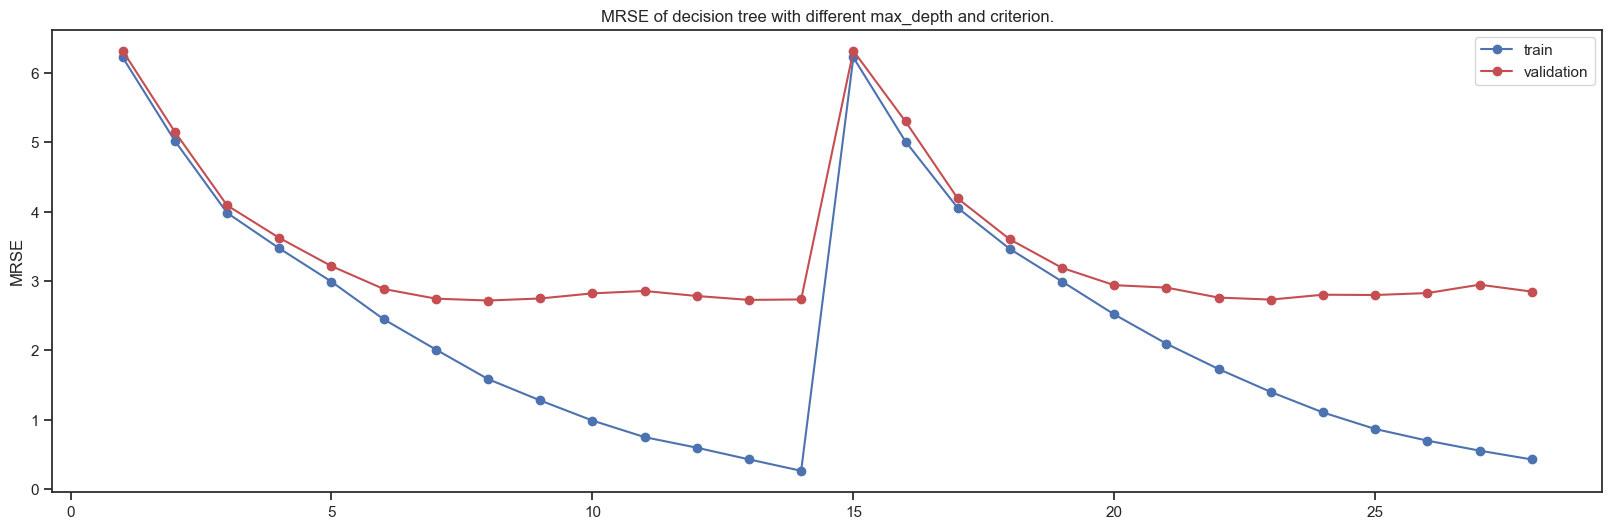

In [38]:
plt.figure(figsize=(20,6))

plt.plot(range(1,29), train_metrics,'ob-')
plt.plot(range(1,29), val_metrics,'or-')

plt.title("MRSE of decision tree with different max_depth and criterion.")
plt.ylabel("MRSE")
plt.legend(['train', 'validation'])

plt.show()

In [34]:
calcul_rmse_mae(clfDTb, Xval, Yval)

Root Mean Squared Error (RMSE): 2.7181
Mean Absolute Error (MAE): 1.8361


So our battle for the final model wins Random forest with hyperparameters {'n_estimators': 15, 'max_samples': 815, 'max_depth': 7}, without normalizing the data and its highest validation RMSE equals to 2.4103. (MAE = 1.6288)

### RMSE of the final model

In [39]:
print("RMSE (train): {0:.6f}".format(metrics.mean_squared_error(Ytrain, clfRFb.predict(Xtrain), squared=False)))
print("RMSE (validation): {0:.6f}".format(metrics.mean_squared_error(Yval, clfRFb.predict(Xval), squared=False)))
print("RMSE (test): {0:.6f}".format(metrics.mean_squared_error(Ytest, clfRFb.predict(Xtest), squared=False)))

RMSE (train): 1.947421
RMSE (validation): 2.410300
RMSE (test): 2.211152


The most important metric RMSE is the test one, it gives us the error, which we can expect from our model on new (unseen) data.  

The RMSE is a commonly used metric for evaluating the accuracy of a regression model. It is the square root of the average squared differences between predicted and actual values. In our case, an RMSE of 2.211152 indicates that, on average, the model's predictions for life expectancy deviate by approximately 2.21 years. Whether our result is considered good depends on the specific context and requirements of its application.  

 

### Prediction of evaluation.csv

Let's read data from evaluation.csv file, apply the same preprocessing modifications as we have done on data.csv, predict target variable with our final model and write predictions into results.csv file.

In [99]:
df_eval = pd.read_csv("evaluation.csv")

In [102]:
# we don't need these features for training our model, but we need to print them into results
countries = df_eval["Country"].tolist()
years = df_eval["Year"].tolist()

In [103]:
# data preprocessing (the same one as we have done)
object_to_num(df_eval, ['Country', 'Status'])
df_eval.drop(columns=columns_to_drop, inplace=True)
df_eval.loc[df_eval["percentage expenditure"] > 100, "percentage expenditure"] = np.nan
for column in df_eval.columns:
    # going through every country
    for country in df_eval["Country"].unique():
        # calculate mean values for certain feature and certain country in training dataset to avoid methodical error
        mean_value = Xtrain.loc[Xtrain["Country"] == country, column].mean()
        # if there is no data for that country, let's take mean from the whole column
        if np.isnan(mean_value):
            mean_value = Xtrain[column].mean()
        df_eval.loc[df_eval["Country"] == country, column] = df_eval.loc[df_eval["Country"] == country, column].fillna(mean_value)
df_eval.drop(columns="Country", inplace=True)

In [104]:
# prediction
predicted_data = clfRFb.predict(df_eval)

result_data = zip(countries, years, predicted_data)
# writing data into CSV file
with open("results.csv", 'w', newline='') as csvfile:
    fieldnames = ["Country", "Year", "Life expectancy"]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()

    for country, year, life_expect in result_data:
        writer.writerow({'Country': country, 'Year': year, 'Life expectancy': life_expect})

In [105]:
# check up the file with predictions
df_result = pd.read_csv("results.csv")
display(df_result.head(5))

,Country,Year,Life expectancy
0,Azerbaijan,2015,74.268274
1,Azerbaijan,2014,74.176025
2,Azerbaijan,2013,74.048629
3,Azerbaijan,2012,74.055623
4,Azerbaijan,2011,73.938025
